In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
from matplotlib import colors
from matplotlib.cm import ScalarMappable,get_cmap
from matplotlib.patches import Patch
from plot_utils import set_size
import warnings

In [2]:
# PLOT PARAMS
plt.rcParams['font.size'] = 8                  
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['lines.linewidth'] = 1           
plt.rcParams['lines.markersize'] = 3
plt.rcParams['figure.figsize'] = (3.5,1.3)
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.size'] = 1.
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.size'] = 1.
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['xtick.major.pad']=1.5
plt.rcParams['ytick.major.pad']=1.5
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['legend.handlelength'] = plt.rcParams['legend.handleheight']
plt.rcParams['legend.title_fontsize'] = 7
plt.rcParams['legend.columnspacing'] = 0.8
plt.rcParams['legend.handletextpad'] = 0.4

plt.rcParams['axes.linewidth'] = 0.5

fmt = 'eps'

In [3]:
phi = 612
gammas = [20,60,180]
beta = 0.4
max_deg = 7
test_length = '5e4'
sim = False

bins = [2,4,6,8,10,12,14,16,18,20]
bins = np.array([-np.inf] + bins + [np.inf])

cmap = get_cmap('gnuplot2')
del_colors = cmap(np.linspace(0.8,0.1,bins.size-1))

thresholds = np.genfromtxt('../threshold/thresholds_test5e4.dat')
safety = 2

/tmp/ipykernel_126582/4061850821.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('gnuplot2')


In [5]:
warnings.filterwarnings('ignore')
max_del_data = np.zeros((len(gammas),max_deg,bins.size-1))

for g,gamma in enumerate(gammas):
    path_exp = '../data/capacities/phi_sweep_gamma'+str(gamma)+'_beta'+str(beta).replace('.','-')+'_long/results/'
    path_sim = '../data/capacities/phi_sweep_gamma'+str(gamma)+'_beta'+str(beta).replace('.','-')+'_long/corresponding_simulation/noise/'
    if sim:
        path = path_sim
    else:
        path = path_exp
    total = 0
    for deg in range(1,max_deg+1):
        filename_exp = 'gamma'+str(gamma)+'_beta'+str(beta).replace('.','-')+'_phi'+str(phi)+'_deg'+str(deg)+'.dat'
        filename_sim = 'sigma0_gamma'+str(gamma)+'_beta'+str(beta).replace('.','-')+'_phi'+str(phi)+'_deg'+str(deg)+'.dat'
        if sim:
            filename= filename_sim
        else:
            filename = filename_exp

        data = np.genfromtxt(path+filename)
        if data.size > 0:
            indices = data[:,:-1]
            caps = data[:,-1]
            # apply threshold
            caps = caps[caps>thresholds[deg-1]**safety]
            max_del = np.max(indices,axis=1)
            total = np.sum(caps)
            for i in range(bins.size-1):
                max_del_data[g,deg-1,i] = np.sum(caps[np.logical_and(max_del >= bins[i],max_del<bins[i+1])])

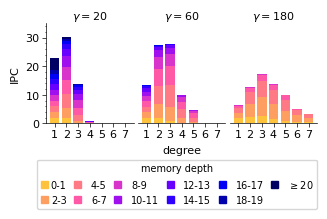

In [6]:
raster = True
dpi = 300


fig = plt.figure()
gs = GridSpec(1,3,wspace=0.05)
ax_low = fig.add_subplot(gs[0])
ax_med = fig.add_subplot(gs[1])
ax_high = fig.add_subplot(gs[2])

degrees = np.arange(1,max_deg+1)
interim_low = np.zeros(degrees.shape)
interim_med = np.zeros(degrees.shape)
interim_high = np.zeros(degrees.shape)
for b in range(max_del_data.shape[-1]):
    ax_low.bar(degrees,max_del_data[0,:,b],bottom=interim_low,color=del_colors[b],rasterized=raster)
    ax_med.bar(degrees,max_del_data[1,:,b],bottom=interim_med,color=del_colors[b],rasterized=raster)
    ax_high.bar(degrees,max_del_data[2,:,b],bottom=interim_high,color=del_colors[b],rasterized=raster)
    interim_low += max_del_data[0,:,b]
    interim_med += max_del_data[1,:,b]
    interim_high += max_del_data[2,:,b]

# legend
handles = [Patch(color=del_colors[d]) for d in range(bins.size-1)]
labels = [str(int(bins[b]-2))+'-'+str(int(bins[b]-1)) for b in range(1,bins.size-1)] + [r'$\geq$'+str(int(bins[-2]))]
leg = fig.legend(ncol=6,loc='upper center',title='memory depth',bbox_to_anchor=(0.5,-0.13),handles=handles,labels=labels,handletextpad=1)

# removing whitespace in front of selfmade legend title
for vpack in leg._legend_handle_box.get_children()[:1]:
    for hpack in vpack.get_children():
        hpack.get_children()[0].set_width(0)

ylim = 35
for ax,gamma in zip([ax_low,ax_med,ax_high],gammas):
    ax.set_title(r'$\gamma=$'+str(gamma),pad=-1)
    ax.set_xticks(range(1,max_deg+1))
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylim([0,ylim])

# removing spines
for ax in [ax_med,ax_high]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

ax_low.set_ylabel('IPC')
ax_med.set_xlabel('degree')
ax_low.set_yticks(range(0,ylim,10))
ax_low.set_yticks(range(0,ylim,2),minor=True)
ax_low.set_yticklabels(range(0,ylim,10))
ax_low.spines['top'].set_visible(False)
ax_low.spines['right'].set_visible(False)


plt.tight_layout()
plt.savefig(fmt+'/fig06_memory_depth.'+fmt,bbox_inches='tight',dpi=dpi)